<a href="https://colab.research.google.com/github/fayeholt/4650-implicit-hate_study/blob/main/BERT_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
source_folder = './'
destination_folder = './model'

In [ ]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import preprocessor as p

In [ ]:
!pip install transformers
!pip install tweet-preprocessor
!pip install nltk
import nltk
nltk.download('stopwords')

     |████████████████████████████████| 2.9 MB 7.0 MB/s 
     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 66.0 MB/s 
     |████████████████████████████████| 596 kB 66.9 MB/s 
     |████████████████████████████████| 3.3 MB 64.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
train_test_ratio = 0.8
train_valid_ratio = 0.99

first_n_words = 512

In [ ]:
df_raw = pd.read_csv('hydrated_hate.csv')
# df_raw = df_raw[df_raw['group'] != 2]
renumbering = {'not_hate':0, 'implicit_hate':1, 'explicit_hate':1}
df_raw['class'] = df_raw['class'].apply(lambda x: renumbering[x])
df_raw = df_raw.drop(['Unnamed: 0'], axis = 1)
df_raw = df_raw[(df_raw['content'] != 'NOT AVAILABLE') & (df_raw['content'] != 'TBD')]
df_raw

,ID,class,content
3,625688620444180481,0,Is Yasir Qadhi a hate preacher for calling Chr...
11,901459720954941440,0,"@occdissent When you said ""we"" are you talking..."
19,939612494796132355,0,RT @mum2kidz2011: @ElderLansing @GrammerSherry...
20,548214253497249792,1,@WhiteResister: Hunt for White Women: Black Ra...
21,538568467545604096,0,“@iLGDaily: If you're racist unfollow me. I ha...
...,...,...,...
21475,SAP_17154,1,"Seeing prostitutes is morally wrong, but being..."
21476,SAP_17179,1,I wonder how many females I raped today I spen...
21477,SAP_17314,1,Having a criminal record is more attractive to...
21478,SAP_17343,1,Another advantage of being a female: getting b...


In [ ]:
df_raw[df_raw['class'] == 1]

,ID,class,content
0,399886440588247041,1,NOT AVAILABLE
6,755109998770921473,1,NOT AVAILABLE
8,934621046224949248,1,NOT AVAILABLE
9,370476364052168705,1,NOT AVAILABLE
18,251422864232808449,1,NOT AVAILABLE
...,...,...,...
21475,SAP_17154,1,"Seeing prostitutes is morally wrong, but being..."
21476,SAP_17179,1,I wonder how many females I raped today I spen...
21477,SAP_17314,1,Having a criminal record is more attractive to...
21478,SAP_17343,1,Another advantage of being a female: getting b...


In [ ]:
total_len = 0 
for row in df_raw.iterrows():
  total_len += len(row[1]['content'].split(" "))
print(total_len / 8464)

16.141422495274103


In [ ]:
df_raw['content'] = df_raw['content'].apply(p.clean)
df_raw

,ID,class,content
3,625688620444180481,0,Is Yasir Qadhi a hate preacher for calling Chr...
11,901459720954941440,0,"When you said ""we"" are you talking about the W..."
19,939612494796132355,0,: CNN wants black people to think the presiden...
20,548214253497249792,1,: Hunt for White Women: Black Racist Serial Ki...
21,538568467545604096,0,: If you're racist unfollow me. I hate you. Yo...
...,...,...,...
21475,SAP_17154,1,"Seeing prostitutes is morally wrong, but being..."
21476,SAP_17179,1,I wonder how many females I raped today I spen...
21477,SAP_17314,1,Having a criminal record is more attractive to...
21478,SAP_17343,1,Another advantage of being a female: getting b...


In [ ]:
import re
from nltk.corpus import stopwords

def rem_stop_punct(text):
  text = text.lower()

  #remove punctuation and split into seperate words
  words = re.findall(r'\w+', text, flags = re.UNICODE) 

  #This is the more pythonic way
  important_words = filter(lambda x: x not in stopwords.words('english'), words)
  return " ".join(important_words)

df_raw['content'] = df_raw['content'].apply(rem_stop_punct)
df_raw

In [ ]:
df_raw.to_csv('./hydrated_hate_2.csv')

In [ ]:
def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

In [ ]:
# Drop rows with empty text
df_raw.drop(df_raw[df_raw.content.str.len() < 10].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['content'] = df_raw['content'].apply(trim_string)

# Split according to label
df_real = df_raw[df_raw['class'] == 0]
df_fake = df_raw[df_raw['class'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(source_folder + '/train.csv', index=False)
df_valid.to_csv(source_folder + '/valid.csv', index=False)
df_test.to_csv(source_folder + '/test.csv', index=False)

In [ ]:
df_train[df_train['class'] == 0]

,ID,class,content
0,774649233278283776,0,Jewrys Move to Shut Down Online Anti-Semitism via
1,521345913608884225,0,: He was advised by police to avoid public app...
2,863144098445889536,0,First celebrated people possibly losing healtt...
3,812747877135085568,0,"an infamous accomplice of jihad, dressed in wh..."
4,872867720282460167,0,"Every people has the right to do this, but we ..."
...,...,...,...
4397,911969425800273921,0,Its time to end open racist
4398,939589104412626946,0,"At , pulls the predictable trick of comparing ..."
4399,617291833048211457,0,what Now? Just hitler was mindless hater despi...
4400,646676445364813824,0,: LIVE: Watch as is welcomed to the White House.


## Prelims

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
a = pd.read_csv('./train.csv')
a[a['class'] == 0]

In [ ]:
|# Model parameter
MAX_SEQ_LEN = 256
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('content', text_field), ('group', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.content),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.content),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 100,
          eval_every = len(train_iter) / 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        print(epoch)
        for (content, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            content = content.type(torch.LongTensor)  
            content = content.to(device)
            output = model(content, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            print(loss.item())
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (content, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        content = content.type(torch.LongTensor)  
                        content = content.to(device)
                        output = model(content, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    print("CURR BEST: " + str(best_valid_loss))
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train(model=model, optimizer=optimizer)

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (content, labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                content = content.type(torch.LongTensor)  
                content = content.to(device)
                output = model(content, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    print(y_true)
    print(y_pred)
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
data = pd.read_csv('train.csv')
# ----- 1. Preprocess data -----#
# Preprocess data
X = list(data["content"])
y = list(data["class"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)


train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    seed=0,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train pre-trained model
trainer.train()

KeyboardInterrupt: ignored

In [ ]:
#!cp -r './output/checkpoint-5500' "/content/drive/My Drive/"
!cp -r './test.csv' "/content/drive/My Drive/"
!cp -r './train.csv' "/content/drive/My Drive/"

In [ ]:
# ----- 3. Predict -----#
# Load test data
test_data = pd.read_csv("test.csv")
X_test = list(test_data["content"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
model_path = "/content/drive/My Drive/checkpoint-8500"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

loading configuration file /content/drive/My Drive/checkpoint-8500/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /content/drive/My Drive/checkpoint-8500/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install interpret

     |████████████████████████████████| 6.6 MB 1.6 MB/s 
     |████████████████████████████████| 296 kB 61.4 MB/s 
     |████████████████████████████████| 275 kB 61.6 MB/s 
     |████████████████████████████████| 371 kB 52.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 756 kB 62.9 MB/s 
     |████████████████████████████████| 7.3 MB 72.1 MB/s 
     |████████████████████████████████| 3.6 MB 45.6 MB/s 
     |████████████████████████████████| 5.8 MB 40.8 MB/s 
     |████████████████████████████████| 788 kB 58.2 MB/s 
     |████████████████████████████████| 124 kB 74.9 MB/s 
     |████████████████████████████████| 23.9 MB 1.1 MB/s 
     |████████████████████████████████| 251 kB 91.9 MB/s 
     |████████████████████████████████| 374 kB 37.6 MB/s 
     |████████████████████████████████| 81 kB 12.7 MB/s 
     |████████████████████████████████| 357 kB 74.5 MB/s 
     |

Classification Report:
              precision    recall  f1-score   support

           1     0.5916    0.6437    0.6166       567
           0     0.8124    0.7764    0.7940      1127

    accuracy                         0.7320      1694
   macro avg     0.7020    0.7101    0.7053      1694
weighted avg     0.7385    0.7320    0.7346      1694

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[Text(0, 0.5, 'HATE'), Text(0, 1.5, 'NOT HATE')]

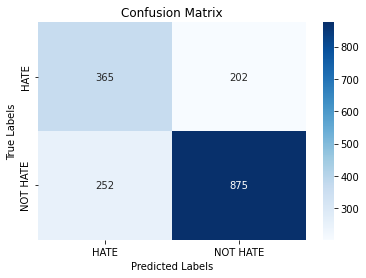

In [ ]:
y_true = list(test_data["class"])
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
print(y_true)
print(y_pred)
    
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['HATE', 'NOT HATE'])
ax.yaxis.set_ticklabels(['HATE', 'NOT HATE'])

In [ ]:
test_data
test_data['class_pred'] = y_pred
test_data = test_data[['ID', 'content', 'class', 'class_pred']]
test_data.to_csv('./test_preds.csv')

In [ ]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    # val = scores
    return val

In [ ]:
import shap
import scipy as sp

In [ ]:
# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

In [ ]:
test_data[-100:]['content']

1594    @FAIRImmigration @bi_politics Great. Zero is a...
1595    How do you get 11 million followers? Run throu...
1596    @PoliticalShort @PoliticalIslam @RussellCPatte...
1597    @ANP14 Within 6 years of life in the US, I bec...
1598    Can someone tell the black people in Chicago t...
                              ...                        
1689    RT @RealistReport: Islamic Scholar APPLAUDED o...
1690    What do you call a fight between a mexican and...
1691    RT @TheaGood: How British Illuminati bankers) ...
1692    @PepeTheShort @PoliticalIslam So you want a la...
1693    @jihadwatchRS Islam is not of this time and mu...
Name: content, Length: 100, dtype: object

In [ ]:
# explain the model's predictions on IMDB reviews
shap_values = explainer(list(test_data[:100]['content']) + list(test_data[-100:]['content']), fixed_context=1)

Partition explainer: 201it [04:54,  1.52s/it]


In [ ]:
shap.plots.text(shap_values[70])

In [ ]:
shap.plots.text(shap_values[-70])

In [ ]:
shap.plots.bar(shap_values[-4])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


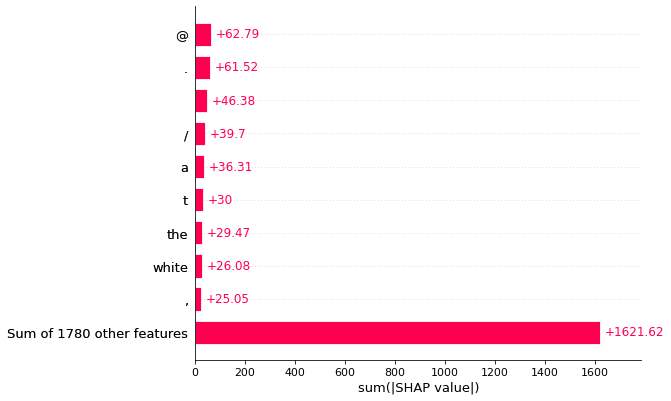

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


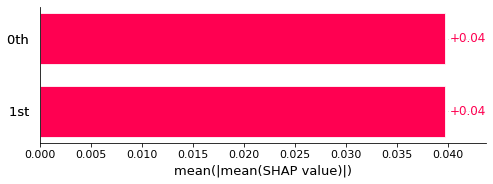

In [ ]:
shap.plots.bar(shap_values[:, :].mean(0))

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


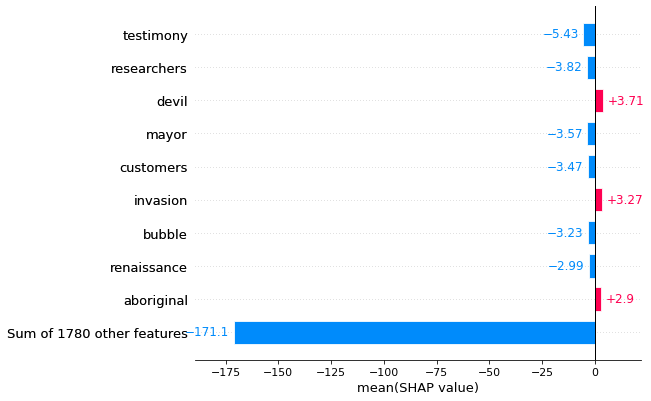

In [ ]:
shap.plots.bar(shap_values[:, :].mean(0))

In [ ]:
shap.plots.bar(shap_values[:, ""])

In [ ]:
type(shap_values)